In [1]:
### Starter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor


In [78]:
def check_irregularities(dataframe):
    print('DataFrame Shape -----------------------')
    print(dataframe.shape)
    print('DataFrame Null Values -----------------------')
    print(dataframe.isna().sum())
    print('DataFrame Duplicates -----------------------')
    print(dataframe.duplicated().sum())
    print('DataFrame Data Types -----------------------')
    print(df.dtypes)

In [26]:
len(df.columns)

10

In [79]:
check_irregularities(df)

DataFrame Shape -----------------------
(640840, 13)
DataFrame Null Values -----------------------
True_index             0
Store_ID               0
Day_of_week            0
Date                   0
Nb_customers_on_day    0
Open                   0
Promotion              0
State_holiday          0
School_holiday         0
Sales                  0
Day_of_year            0
week_num               0
Week_num               0
dtype: int64
DataFrame Duplicates -----------------------
0
DataFrame Data Types -----------------------
True_index                      int64
Store_ID                        int64
Day_of_week                     int64
Date                   datetime64[ns]
Nb_customers_on_day             int64
Open                            int64
Promotion                       int64
State_holiday                   int64
School_holiday                  int64
Sales                           int64
Day_of_year                     int32
week_num                       object
Week_num       

In [45]:
def clean_dataframe(name):
    if name == 'original':
        url = "https://raw.githubusercontent.com/data-bootcamp-v4/data/main/sales.csv"
        dataframe = pd.read_csv(url, index_col=None)
    else:
        dataframe = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv')
    function_df = dataframe.copy()
    function_df['Date'] = pd.to_datetime(function_df['Date'])
    function_df['Week_num'] = function_df['Date'].dt.strftime('%U').astype('int32')
    holiday_map = {'0': 0, 'a':1, 'b':1, 'c':1}
    function_df['State_holiday'] = function_df['State_holiday'].map(holiday_map)
    if len(function_df.columns) > 10:
        selection_df = function_df[['Week_num', 'Day_of_week', 'Nb_customers_on_day', 'Promotion', 'State_holiday', 'School_holiday', 'Sales']]
    else:
        selection_df = function_df[['Week_num', 'Day_of_week', 'Nb_customers_on_day', 'Promotion', 'State_holiday', 'School_holiday']]

    return selection_df

In [28]:
final_df = clean_dataframe(df)

In [29]:
display(final_df.head())

,Week_num,Day_of_week,Nb_customers_on_day,Promotion,State_holiday,School_holiday,Sales
0,44,3,641,1,0,0,7293
1,28,2,877,1,0,1,7060
2,3,4,561,1,0,0,4565
3,38,4,1584,1,0,0,6380
4,3,3,1477,1,0,0,11647


<Axes: >

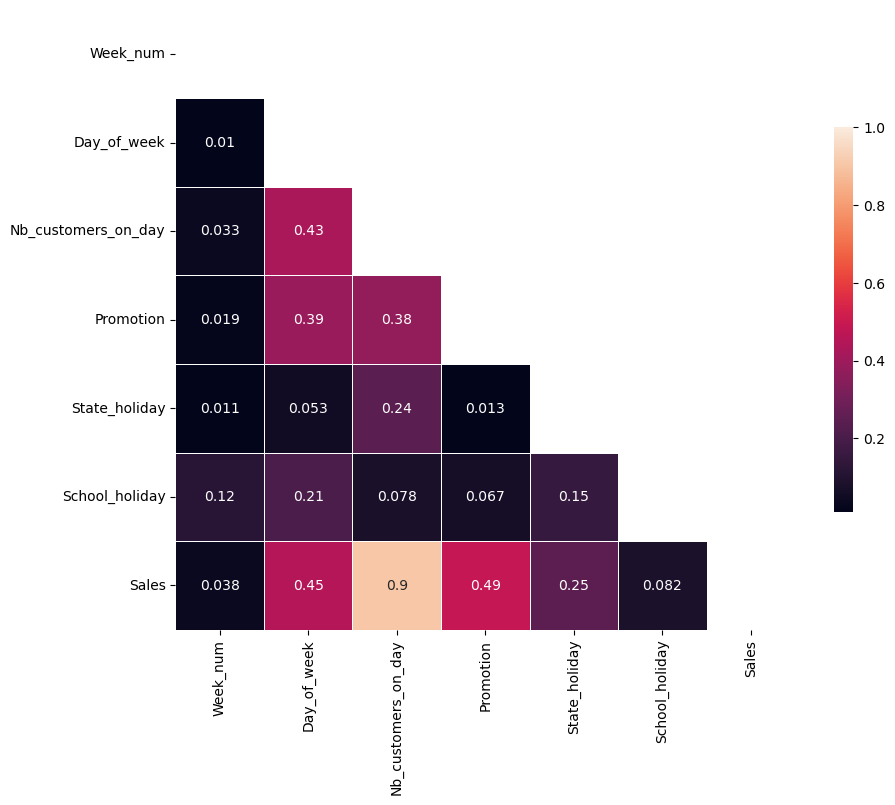

In [6]:
corr=np.abs(final_df.corr('spearman'))
#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)


In [7]:
features = final_df.drop(columns = ['Sales'])
target = final_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20)

In [8]:
normalizer = MinMaxScaler()
normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

In [ ]:
def get_score_matrix(model, model_name):
    
    train_pred = model.predict(X_train_norm)
    test_pred = model.predict(X_test_norm)
    
    train_metrics = {
        'Model': model_name,
        'Dataset': 'Train',
        'MAE': mean_absolute_error(y_train, train_pred),
        'RMSE': root_mean_squared_error(y_train, train_pred),
        'R2 Score': r2_score(y_train, train_pred)
    }
    
    test_metrics = {
        'Model': model_name,
        'Dataset': 'Test',
        'MAE': mean_absolute_error(y_test, test_pred),
        'RMSE': root_mean_squared_error(y_test, test_pred),
        'R2 Score': r2_score(y_test, test_pred)
    }
    
    df = pd.DataFrame([train_metrics, test_metrics])
    
    return df

In [ ]:
models = [
    ('XGB' , XGBRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('Bagging (DT)', BaggingRegressor(DecisionTreeRegressor())),
    ('Random Forest', RandomForestRegressor()),
    ('AdaBoost (DT)', AdaBoostRegressor(DecisionTreeRegressor())),
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor())
]

results = []

for name, model in models:
    model.fit(X_train_norm, y_train)
    df = get_score_matrix(model, name)
    results.append(df)

comparison_matrix = pd.concat(results).reset_index(drop=True)

In [ ]:
display(comparison_matrix)

,Model,Dataset,MAE,RMSE,R2 Score
0,Gradient Boosting,Train,890.053715,1329.697154,0.880930
1,Gradient Boosting,Test,890.937781,1327.187973,0.880719
2,Bagging (DT),Train,546.434603,843.104016,0.952130
3,Bagging (DT),Test,995.525954,1505.786498,0.846456
4,Random Forest,Train,529.090034,799.032188,0.957004
5,Random Forest,Test,975.561889,1473.178250,0.853034
6,AdaBoost (DT),Train,409.753771,735.463495,0.963573
7,AdaBoost (DT),Test,1048.877951,1609.893992,0.824490
8,Linear Regression,Train,1068.753880,1523.577338,0.843675
9,Linear Regression,Test,1061.644814,1505.218731,0.846572


,Model,Dataset,MAE,RMSE,R2 Score
0,XGB,Train,858.316654,1290.673743,0.887816
1,XGB,Test,867.494216,1309.876467,0.883811
2,Gradient Boosting,Train,890.053715,1329.697154,0.880930
3,Gradient Boosting,Test,890.937781,1327.187973,0.880719
4,Bagging (DT),Train,546.474775,843.608228,0.952073
5,Bagging (DT),Test,996.682401,1508.009402,0.846002
6,Random Forest,Train,529.320341,799.190156,0.956987
7,Random Forest,Test,975.717311,1472.613327,0.853147
8,AdaBoost (DT),Train,403.983523,733.097819,0.963807
9,AdaBoost (DT),Test,1060.662950,1626.212665,0.820914


In [11]:
import pickle

In [16]:
models[0][1]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
pickle.dump(models[0][1], open('model.pkl', 'wb'))

In [ ]:
pickle.load(models[0][1], open('model.pkl', 'rb'))

In [71]:
models = [
    ('XGB Model', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)),
    ('Bagging (DT)', BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=50)),
    ('Random Forest', RandomForestRegressor(n_estimators=100, max_depth=7)),
    ('AdaBoost (DT)', AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators=100, learning_rate=0.1)),
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(max_depth=5))
]

# Lista para almacenar resultados
results = []

# Entrenamos y obtenemos score matrix por modelo
for name, model in models:
    model.fit(X_train_norm, y_train)
    df = get_score_matrix(model, name)
    results.append(df)

# Unimos todo en un único DataFrame
comparison_matrix_params = pd.concat(results).reset_index(drop=True)

In [46]:
display(comparison_matrix_params)

,Model,Dataset,MAE,RMSE,R2 Score
0,XGB Model,Train,860.467830,1292.432751,0.887510
1,XGB Model,Test,868.223522,1310.574913,0.883687
2,Gradient Boosting,Train,890.053715,1329.697154,0.880930
3,Gradient Boosting,Test,890.937781,1327.187973,0.880719
4,Bagging (DT),Train,941.175764,1430.672268,0.862159
5,Bagging (DT),Test,939.753998,1424.201280,0.862644
6,Random Forest,Train,894.435985,1356.907637,0.876006
7,Random Forest,Test,895.032267,1352.892723,0.876054
8,AdaBoost (DT),Train,1092.955694,1593.624271,0.828971
9,AdaBoost (DT),Test,1094.187794,1588.199809,0.829189


In [ ]:

gbr = GradientBoostingRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10]
}

scorer = make_scorer(mean_absolute_error)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=5,
    scoring=scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_norm, y_train)

print("Mejores parámetros:", random_search.best_params_)
print("Mejor R2 (CV):", random_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.01}
Mejor R2 (CV): 938.3444043234631


In [50]:
for col in final_df.columns:
    print(final_df[col].value_counts())

Week_num
20    14947
12    14880
25    14853
22    14852
8     14833
1     14805
11    14792
21    14759
7     14759
24    14749
19    14740
13    14740
18    14737
6     14732
10    14731
17    14722
4     14720
23    14719
2     14718
16    14711
15    14709
5     14695
14    14692
3     14682
9     14660
26    14099
28    13985
27    13954
29    13861
30    13315
39     9162
47     9088
43     9084
36     9078
51     9059
45     9055
48     9051
50     9050
40     9041
32     9034
37     9034
33     9028
46     9024
44     9014
41     9013
38     8995
49     8994
34     8989
31     8982
42     8973
35     8959
0      8496
52     4486
Name: count, dtype: int64
Day_of_week
5    92138
4    91972
2    91686
3    91651
6    91347
7    91075
1    90971
Name: count, dtype: int64
Nb_customers_on_day
0       108854
560       1539
517       1507
571       1493
528       1492
         ...  
3651         1
4228         1
4037         1
3737         1
4517         1
Name: count, Length: 3886, dt

In [47]:
pred_df = clean_dataframe('pred')

In [50]:
predicted_sales = models[0][1].predict(pred_df)

In [58]:
submission = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/ironkaggle_notarget.csv')

In [59]:
submission['Sales'] = predicted_sales

In [66]:
def get_closed_sales(row):
    if row['Open'] == 0:
        return 0
    else:
        return row['Sales']

In [68]:
submission['Sales'] = submission.apply(get_closed_sales, axis=1)

In [69]:
submission = submission[['True_index', 'Sales']]

In [70]:
submission.to_csv('Burak_Santi_submission.csv')